In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

def get_statiz_batter_stats(season=2024):
    url = f'http://www.statiz.co.kr/stat_at.php?opt=0&sopt=0&sy={season}&se={season}'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    table = soup.find('table', {'class':'table'})
    df = pd.read_html(str(table))[0]
    df = df[df['순번'] != '순번']  # 헤더 반복 제거
    df = df.reset_index(drop=True)
    # 필요한 컬럼만 추출
    df = df[['이름', '팀', '타율', '출루', '타수', '경기']]
    df['타율'] = pd.to_numeric(df['타율'], errors='coerce')
    df['출루'] = pd.to_numeric(df['출루'], errors='coerce')
    df['가중치점수'] = df['타율']*0.7 + df['출루']*0.3
    return df


In [ ]:
def get_top5(df):
    return df.sort_values('가중치점수', ascending=False).head(5)



In [ ]:
# app.py
import streamlit as st

# 1. Top5
st.header("KBO Top5 타자 (가중치 기준)")
top5 = get_top5(df)
st.dataframe(top5)

# 2. 선수명 검색
name = st.text_input("선수명 입력")
if name:
    # 크롤링 함수로 선수 최근 10경기, 사진 등 불러오기
    st.image(player_img_url)
    st.dataframe(player_last10_df)

# 3. 팀명 검색
team = st.text_input("팀명 입력")
if team:
    # 팀별 투수 성적 테이블/차트
    st.dataframe(team_pitcher_df)
    st.pyplot(team_pitcher_chart_fig)


In [ ]:
%matplotlib inline


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

# 아래에 기존 그래프 코드 작성


In [ ]:
import matplotlib.pyplot as plt

years = [2020, 2021, 2022, 2023, 2024]

teams = [
    ("삼성",     [139081, 363800, 688313, 1275022, 1347022]),
    ("LG",       [181097, 410668, 708845, 1273906, 1397499]),
    ("두산",     [171071, 394372, 693234, 1190821, 1301768]),
    ("롯데",     [208335, 420004, 724553, 1089055, 1232840]),
    ("KIA",      [161293, 412488, 675202, 1156749, 1259249]),
    ("SSG",      [154889, 384073, 654733, 1040014, 1143773]),
    ("한화",     [129098, 340071, 620313, 745797, 808350]),
    ("키움",     [146062, 366414, 667015, 781318, 804204]),
    ("NC",       [99313, 315309, 629442, 749058, 749058]),
    ("KT",       [125920, 346911, 635129, 718243, 843942])
]

plt.figure(figsize=(13,7))
for team, data in teams:
    plt.plot(years, data, marker='o', label=team)

plt.title("KBO 구단별 연도별 홈경기 총관중수 변화 (2020~2024)", fontsize=15)
plt.xlabel("연도", fontsize=13)
plt.ylabel("총 관중수", fontsize=13)
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 예시 데이터 (구단별, 연도별 순위와 관중수)
data = {
    'year':    [2020, 2021, 2022, 2023, 2024],
    '삼성_순위': [8, 2, 7, 6, 5],
    '삼성_관중': [139081, 363800, 688313, 1275022, 1347022],
    # 아래에 각 구단 추가
}

df = pd.DataFrame(data)
rank = df['삼성_순위']
crowd = df['삼성_관중']

r, p = pearsonr(rank, crowd)
print(f"삼성: 순위-관중수 상관계수 = {r:.3f}, p-value = {p:.3f}")


In [ ]:
import requests
from datetime import datetime, timedelta

# 1. 구장, 도시, 격자좌표(nx, ny) 매핑
stadium_dict = {
    # 구단명, 구장명, 도시명 등 여러 키워드 입력 지원
    "두산":    {"stadium": "잠실야구장", "city": "서울", "nx": 62, "ny": 126},
    "LG":     {"stadium": "잠실야구장", "city": "서울", "nx": 62, "ny": 126},
    "잠실":    {"stadium": "잠실야구장", "city": "서울", "nx": 62, "ny": 126},
    "키움":    {"stadium": "고척스카이돔", "city": "서울", "nx": 58, "ny": 125},
    "고척":    {"stadium": "고척스카이돔", "city": "서울", "nx": 58, "ny": 125},
    "한화":    {"stadium": "대전한화생명", "city": "대전", "nx": 67, "ny": 100},
    "대전":    {"stadium": "대전한화생명", "city": "대전", "nx": 67, "ny": 100},
    "KIA":    {"stadium": "광주챔피언스필드", "city": "광주", "nx": 58, "ny": 74},
    "광주":    {"stadium": "광주챔피언스필드", "city": "광주", "nx": 58, "ny": 74},
    "KT":     {"stadium": "수원KT위즈파크", "city": "수원", "nx": 60, "ny": 121},
    "수원":    {"stadium": "수원KT위즈파크", "city": "수원", "nx": 60, "ny": 121},
    "NC":     {"stadium": "창원NC파크", "city": "창원", "nx": 91, "ny": 77},
    "창원":    {"stadium": "창원NC파크", "city": "창원", "nx": 91, "ny": 77},
    "삼성":    {"stadium": "대구라이온즈파크", "city": "대구", "nx": 89, "ny": 90},
    "대구":    {"stadium": "대구라이온즈파크", "city": "대구", "nx": 89, "ny": 90},
    "롯데":    {"stadium": "사직야구장", "city": "부산", "nx": 98, "ny": 76},
    "부산":    {"stadium": "사직야구장", "city": "부산", "nx": 98, "ny": 76},
    "SSG":    {"stadium": "인천SSG랜더스필드", "city": "인천", "nx": 54, "ny": 124},
    "인천":    {"stadium": "인천SSG랜더스필드", "city": "인천", "nx": 54, "ny": 124},
}

# 2. 사용자 입력 받기
keyword = input("구단명/구장명/도시명을 입력하세요: ").strip()
info = stadium_dict.get(keyword)
if not info:
    print("해당 구단/구장/도시 정보가 없습니다.")
    exit()

stadium = info['stadium']
city = info['city']
nx, ny = info['nx'], info['ny']

# 3. 날짜·시간(기상청 단기예보 base_date, base_time) 자동 계산
# 기준: 2, 5, 8, 11, 14, 17, 20, 23시만 가능 (API 문서 참고)
now = datetime.now()
base_times = [2, 5, 8, 11, 14, 17, 20, 23]
hour = max([bt for bt in base_times if now.hour >= bt])
if now.hour < 2:
    base_date = (now - timedelta(days=1)).strftime("%Y%m%d")
else:
    base_date = now.strftime("%Y%m%d")
base_time = f"{hour:02d}00"

# 4. 기상청 단기예보 API 호출
service_key = "ZVGaMkpup%2Fiw%2B2A40tOW5I7j5K65kPZh0xxqJcaB4xTz06dGebsUORU%2BxDD%2FSjzrOrDpc9D1R8zijOVYBWmBoA%3D%3D"  # 인코딩된 인증키 입력!
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
params = {
    "serviceKey": service_key,
    "pageNo": "1",
    "numOfRows": "50",
    "dataType": "JSON",
    "base_date": base_date,
    "base_time": base_time,
    "nx": nx,
    "ny": ny
}
response = requests.get(url, params=params)
items = response.json()['response']['body']['items']['item']

# 5. 기온(T1H), 날씨코드(PTY, SKY) 추출
fcst = {}
for item in items:
    category = item['category']
    if category in ['T1H', 'PTY', 'SKY']:  # T1H=기온, PTY=강수형태, SKY=하늘상태
        fcst[category] = item['fcstValue']

# 6. 날씨 텍스트 변환
pty_map = {'0': '없음', '1': '비', '2': '비/눈', '3': '눈', '4': '소나기'}
sky_map = {'1': '맑음', '3': '구름많음', '4': '흐림'}
pty = pty_map.get(fcst.get('PTY', '0'), '정보없음')
sky = sky_map.get(fcst.get('SKY', '1'), '정보없음')
temp = fcst.get('T1H', '정보없음')

# 7. 결과 출력
print(f"\n[{stadium}] ({city})")
print(f"- 현재 온도: {temp}℃")
print(f"- 날씨: {sky} / 강수: {pty}")

print(response.text)   # response.json() 대신 response.text로 확인


In [3]:
import requests
from datetime import datetime, timedelta

def get_weather(nx, ny, service_key):
    """
    nx, ny: 기상청 격자 좌표
    service_key: 기상청 인증키 (인코딩된 상태)
    """
    # 현재 시간 기준으로 base_date, base_time 설정 (2,5,8,11,14,17,20,23시 기준)
    now = datetime.now()
    base_times = [2,5,8,11,14,17,20,23]
    base_time = max([bt for bt in base_times if now.hour >= bt]) if now.hour >= 2 else 23
    base_date = now.strftime("%Y%m%d") if now.hour >= 2 else (now - timedelta(days=1)).strftime("%Y%m%d")
    base_time_str = f"{base_time:02d}00"

    url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    params = {
        "serviceKey": service_key,
        "pageNo": "1",
        "numOfRows": "50",
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time_str,
        "nx": nx,
        "ny": ny
    }

    response = requests.get(url, params=params)
    response.raise_for_status()  # 실패시 에러 발생

    data = response.json()

    items = data['response']['body']['items']['item']

    # 필요한 데이터만 필터링 (예: 기온 T1H, 강수형태 PTY, 하늘상태 SKY)
    weather_info = {}
    for item in items:
        category = item['category']
        if category in ['T1H', 'PTY', 'SKY']:
            weather_info[category] = item['fcstValue']

    # 날씨 상태 매핑
    pty_map = {'0': '없음', '1': '비', '2': '비/눈', '3': '눈', '4': '소나기'}
    sky_map = {'1': '맑음', '3': '구름많음', '4': '흐림'}

    temp = weather_info.get('T1H', '정보없음')
    pty = pty_map.get(weather_info.get('PTY', '0'), '정보없음')
    sky = sky_map.get(weather_info.get('SKY', '1'), '정보없음')

    return {"기온": temp, "강수": pty, "하늘상태": sky}


In [7]:
service_key = "ZVGaMkpup%2Fiw%2B2A40tOW5I7j5K65kPZh0xxqJcaB4xTz06dGebsUORU%2BxDD%2FSjzrOrDpc9D1R8zijOVYBWmBoA%3D%3D"
nx, ny = 62, 126  # 서울 잠실 예시

weather = get_weather(nx, ny, service_key)
print(weather)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [6]:
print("Status code:", response.status_code)
print("Response text:", repr(response.text))  # 빈 문자열인지 확인


Status code: 200
Response text: '<OpenAPI_ServiceResponse>\n\t<cmmMsgHeader>\n\t\t<errMsg>SERVICE ERROR</errMsg>\n\t\t<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>\n\t\t<returnReasonCode>30</returnReasonCode>\n\t</cmmMsgHeader>\n</OpenAPI_ServiceResponse>'


In [9]:
service_key = "ZVGaMkpup%2Fiw%2B2A40tOW5I7j5K65kPZh0xxqJcaB4xTz06dGebsUORU%2BxDD%2FSjzrOrDpc9D1R8zijOVYBWmBoA%3D%3D"

params = {
    "serviceKey": service_key,
    "pageNo": "1",
    "numOfRows": "50",
    "dataType": "JSON",
    "base_date": base_date,
    "base_time": base_time,
    "nx": nx,
    "ny": ny
}

response = requests.get(url, params=params)
print("Status code:", response.status_code)
print("Response text:", response.text)


Status code: 200
Response text: <OpenAPI_ServiceResponse>
	<cmmMsgHeader>
		<errMsg>SERVICE ERROR</errMsg>
		<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>
		<returnReasonCode>30</returnReasonCode>
	</cmmMsgHeader>
</OpenAPI_ServiceResponse>


In [11]:
import requests

service_key = "ZVGaMkpup/iw+2A40tOW5I7j5K65kPZh0xxqJcaB4xTz06dGebsUORU+xDD/SjzrOrDpc9D1R8zijOVYBWmBoA=="

params = {
    "serviceKey": service_key,
    "pageNo": "1",
    "numOfRows": "1",
    "dataType": "JSON",
    "base_date": "20250731",  # 오늘 날짜로 수정 필요
    "base_time": "1400",      # base_time 유효한 시간으로 수정 필요
    "nx": 62,
    "ny": 126
}

response = requests.get(
    "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst",
    params=params
)

print("Status:", response.status_code)
print("Response:", response.text)


Status: 200
Response: {"response":{"header":{"resultCode":"03","resultMsg":"NO_DATA"}}}


In [12]:
from datetime import datetime, timedelta

def get_base_date_time():
    now = datetime.now()
    base_times = [2, 5, 8, 11, 14, 17, 20, 23]
    base_time = max([bt for bt in base_times if now.hour >= bt]) if now.hour >= 2 else 23
    base_date = now.strftime("%Y%m%d") if now.hour >= 2 else (now - timedelta(days=1)).strftime("%Y%m%d")
    return base_date, f"{base_time:02d}00"

base_date, base_time = get_base_date_time()
print(base_date, base_time)


20250731 1100


In [13]:
import requests
from datetime import datetime, timedelta

def get_latest_base_date_time():
    """
    현재 시각 기준으로 기상청 API의 base_date, base_time 계산
    base_time은 2,5,8,11,14,17,20,23시 중 가장 최근 과거 시각
    """
    now = datetime.now()
    base_times = [2, 5, 8, 11, 14, 17, 20, 23]

    valid_times = [bt for bt in base_times if now.hour >= bt]
    if valid_times:
        base_time = max(valid_times)
        base_date = now.strftime("%Y%m%d")
    else:
        base_time = 23
        base_date = (now - timedelta(days=1)).strftime("%Y%m%d")

    return base_date, f"{base_time:02d}00"

def get_weather(nx, ny, service_key):
    """
    nx, ny: 기상청 격자 좌표
    service_key: 인코딩된 기상청 인증키
    """
    base_date, base_time = get_latest_base_date_time()

    url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    params = {
        "serviceKey": service_key,
        "pageNo": "1",
        "numOfRows": "50",
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": nx,
        "ny": ny
    }

    response = requests.get(url, params=params)
    response.raise_for_status()

    data = response.json()

    items = data['response']['body']['items']['item']

    weather_info = {}
    for item in items:
        if item['category'] in ['T1H', 'PTY', 'SKY']:
            weather_info[item['category']] = item['fcstValue']

    pty_map = {'0': '없음', '1': '비', '2': '비/눈', '3': '눈', '4': '소나기'}
    sky_map = {'1': '맑음', '3': '구름많음', '4': '흐림'}

    temp = weather_info.get('T1H', '정보없음')
    pty = pty_map.get(weather_info.get('PTY', '0'), '정보없음')
    sky = sky_map.get(weather_info.get('SKY', '1'), '정보없음')

    return {
        "base_date": base_date,
        "base_time": base_time,
        "기온": temp,
        "강수": pty,
        "하늘상태": sky
    }

# ===== 사용 예시 =====
if __name__ == "__main__":
    # 본인 인증키 입력 (인코딩된 키 사용)
    service_key = "ZVGaMkpup/iw+2A40tOW5I7j5K65kPZh0xxqJcaB4xTz06dGebsUORU+xDD/SjzrOrDpc9D1R8zijOVYBWmBoA=="

    # 예) 서울 잠실 격자 좌표
    nx, ny = 62, 126

    weather = get_weather(nx, ny, service_key)
    print(weather)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [14]:
response = requests.get(url, params=params)

print("Status:", response.status_code)
print("Response:", repr(response.text))

try:
    data = response.json()
except Exception as e:
    print("JSONDecodeError:", e)
    data = None

if data is None:
    print("API 응답이 JSON 형식이 아닙니다. 응답 내용을 확인해주세요.")
else:
    # 정상 처리 코드


SyntaxError: incomplete input (1493000933.py, line 15)

In [15]:
print("Status code:", response.status_code)
print("Response text:", repr(response.text))


Status code: 200
Response text: '{"response":{"header":{"resultCode":"03","resultMsg":"NO_DATA"}}}'


In [16]:
from datetime import datetime, timedelta

def get_latest_base_date_time():
    now = datetime.now()
    base_times = [2, 5, 8, 11, 14, 17, 20, 23]

    valid_times = [t for t in base_times if now.hour >= t]
    if valid_times:
        base_time = max(valid_times)
        base_date = now.strftime("%Y%m%d")
    else:
        base_time = 23
        base_date = (now - timedelta(days=1)).strftime("%Y%m%d")

    return base_date, f"{base_time:02d}00"

# 사용
base_date, base_time = get_latest_base_date_time()
print(base_date, base_time)


20250731 1100


In [18]:
def get_weahter():
params = {
"q": "37.5665,126.9780",
"lon": 126.9780,
"key": "4706749edceb4016a8220808253107".strip(),
"units": "metric",
"lang": "k"
}

res = requests.get("https://api.weatherapi.com/v1/current.json", params=params);

if res.ok:
    data = res.json()
    temperature = data["current"]["temp_c"] # 온도 (℃)
    wind_speed = data["current"]["wind_kph"] # 바람 속도 (km/h)
    humidity = data["current"]["humidity"] # 습도 (%)

# 출력
print(f"🌡️ 온도: {temperature}°C")
print(f"💨 바람: {wind_speed} km/h")
print(f"💧 습도: {humidity}%")


get_weahter();

IndentationError: expected an indented block after function definition on line 1 (2478108012.py, line 2)

In [19]:
import requests

def get_weather():
    params = {
        "q": "37.5665,126.9780",  # 위도,경도 (서울 예시)
        "key": "4706749edceb4016a8220808253107",
        "units": "metric",
        "lang": "ko"
    }

    res = requests.get("https://api.weatherapi.com/v1/current.json", params=params)

    if res.ok:
        data = res.json()
        temperature = data["current"]["temp_c"]       # 온도 (℃)
        wind_speed = data["current"]["wind_kph"]      # 바람 속도 (km/h)
        humidity = data["current"]["humidity"]        # 습도 (%)

        # 출력
        print(f"🌡️ 온도: {temperature}°C")
        print(f"💨 바람: {wind_speed} km/h")
        print(f"💧 습도: {humidity}%")
    else:
        print("API 요청 실패:", res.status_code)

get_weather()


🌡️ 온도: 33.2°C
💨 바람: 4.3 km/h
💧 습도: 56%


In [ ]:
import pandas as pd

data = {
    '순위':         [2, 3, 5, 7, 8, 6, 4, 1, 9, 10],
    '인구대비관중비율':[0.204, 0.195, 0.769, 0.526, 0.738, 1.232, 0.555, 0.990, 0.978, 0.120],
    '구단나이':      [43, 43, 43, 43, 39, 43, 23, 10, 13, 16],
    '접근성':        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
    'SNS팔로워':     [90000, 80000, 65000, 60000, 45000, 40000, 40000, 35000, 35000, 30000],
    '평균관중':      [19144, 18335, 18452, 17364, 11073, 17250, 16109, 11887, 10261, 11327]
}
df = pd.DataFrame(data)

print(df.corr(numeric_only=True)['평균관중'])
corr()

In [22]:
%matplotlib inline

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

# 아래에 기존 그래프 코드 작성


[상관계수 분석]
평균관중        1.000000
SNS팔로워      0.781436
구단나이        0.771571
접근성         0.202979
인구대비관중비율   -0.251169
순위         -0.522842
Name: 평균관중, dtype: float64

[다중 회귀분석 결과]
                            OLS Regression Results                            
Dep. Variable:                   평균관중   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     3.625
Date:                Thu, 31 Jul 2025   Prob (F-statistic):              0.118
Time:                        14:48:20   Log-Likelihood:                -86.839
No. Observations:                  10   AIC:                             185.7
Df Residuals:                       4   BIC:                             187.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err

c:\Users\user\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


<Figure size 1200x800 with 0 Axes>

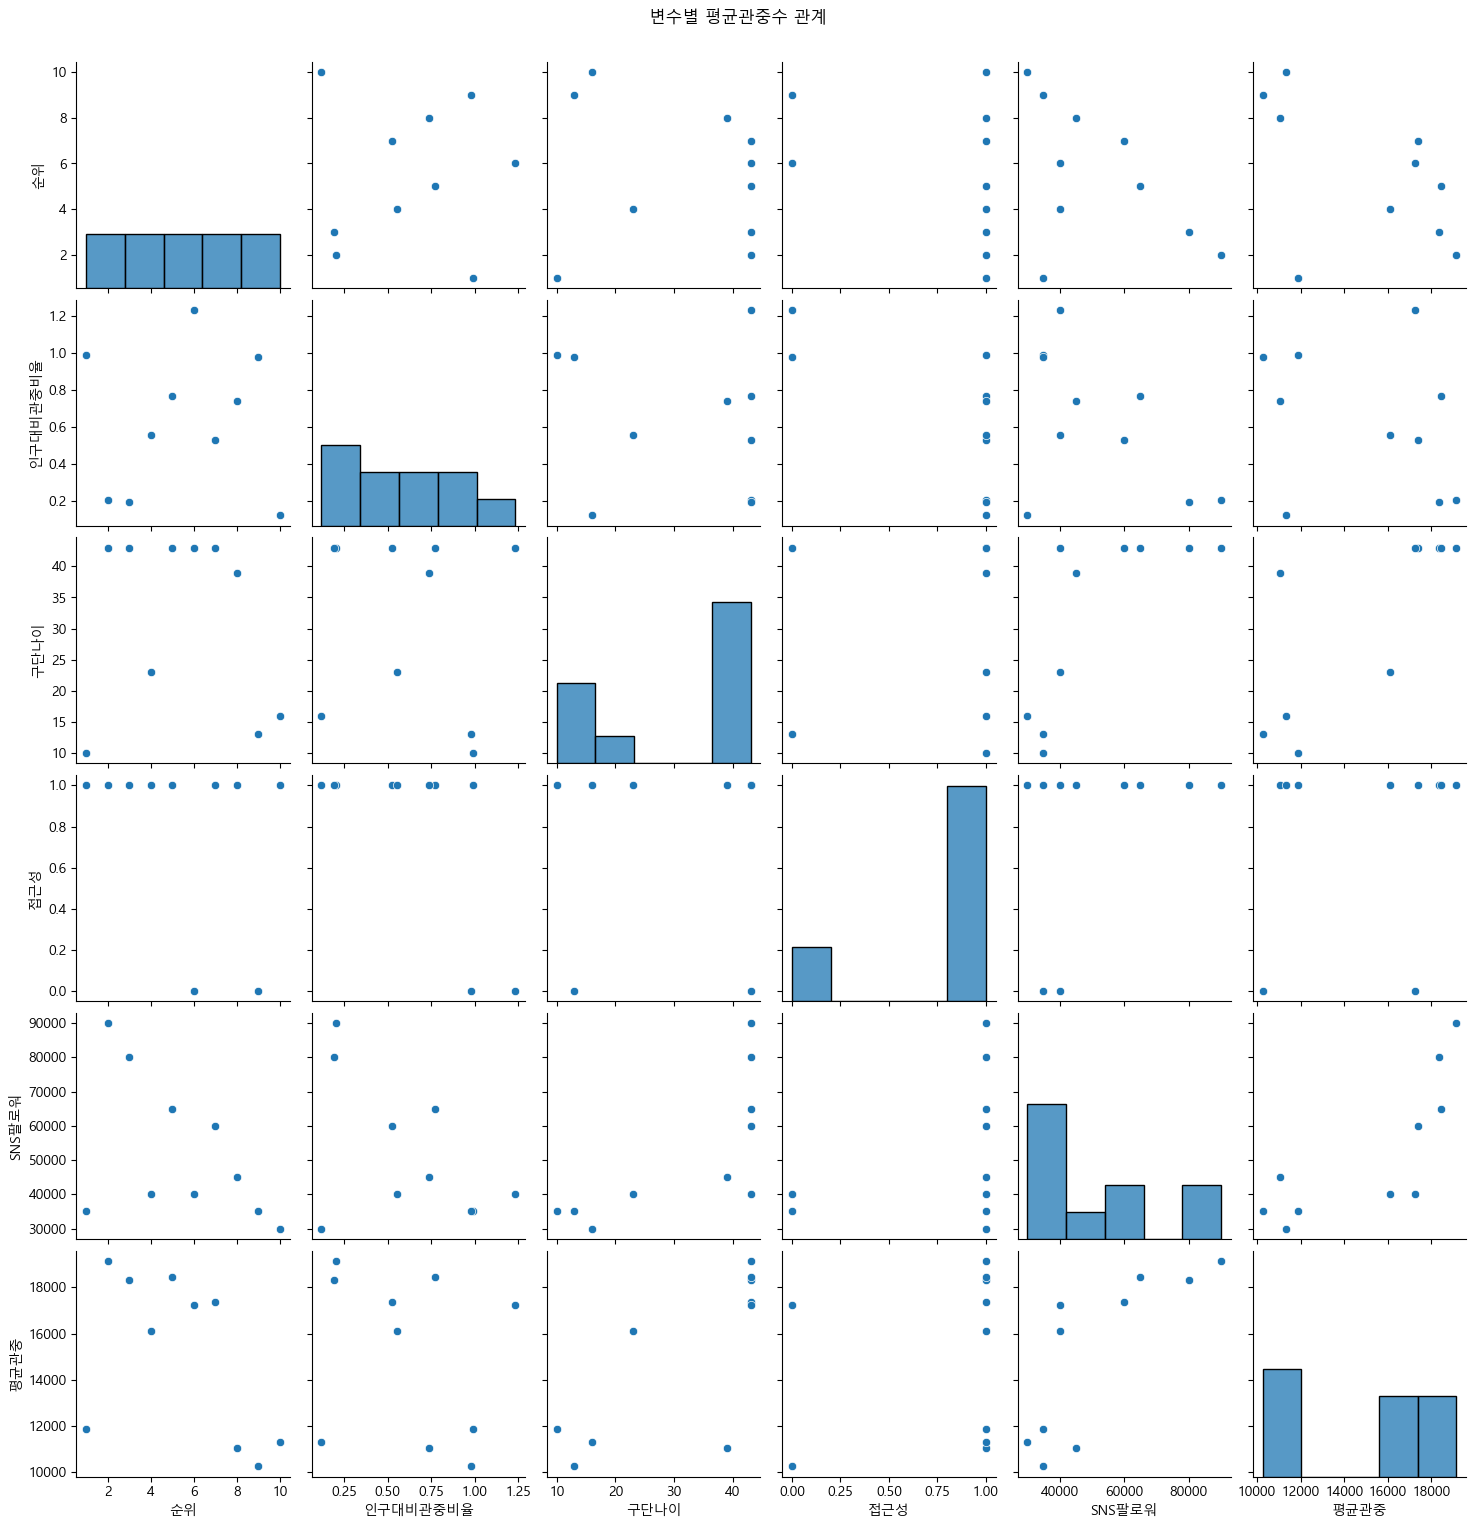

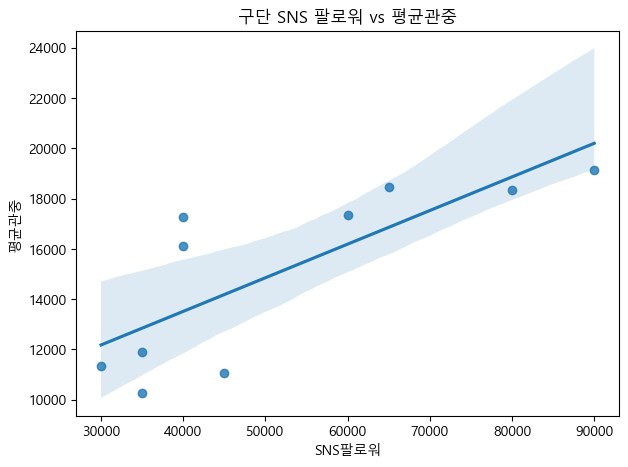

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 데이터
data = {
    '구단':        ['LG','두산','삼성','롯데','한화','KIA','SSG','KT','NC','키움'],
    '순위':        [2, 3, 5, 7, 8, 6, 4, 1, 9, 10],
    '도시인구':    [9400000, 9400000, 2400000, 3300000, 1500000, 1400000, 2900000, 1200000, 1050000, 9400000],
    '평균관중':    [19144, 18335, 18452, 17364, 11073, 17250, 16109, 11887, 10261, 11327],
    '구단나이':    [43, 43, 43, 43, 39, 43, 23, 10, 13, 16],
    '접근성':      [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
    'SNS팔로워':   [90000, 80000, 65000, 60000, 45000, 40000, 40000, 35000, 35000, 30000]
}

df = pd.DataFrame(data)
df['인구대비관중비율'] = (df['평균관중'] / df['도시인구']) * 100   # 백분율

# 1. 상관계수 분석
print("\n[상관계수 분석]")
corrs = df[['순위', '인구대비관중비율', '구단나이', '접근성', 'SNS팔로워', '평균관중']].corr()
print(corrs['평균관중'].sort_values(ascending=False))

# 2. 다중 선형회귀분석
print("\n[다중 회귀분석 결과]")
X = df[['순위', '인구대비관중비율', '구단나이', '접근성', 'SNS팔로워']]
y = df['평균관중']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# 3. 변수별 산점도 시각화 (선택)
plt.figure(figsize=(12, 8))
sns.pairplot(df[['순위','인구대비관중비율','구단나이','접근성','SNS팔로워','평균관중']])
plt.suptitle('변수별 평균관중수 관계', y=1.02)
plt.show()

# 4. 평균관중 ~ SNS 팔로워 단일 회귀시각화 (예시)
plt.figure(figsize=(7,5))
sns.regplot(x='SNS팔로워', y='평균관중', data=df)
plt.title('구단 SNS 팔로워 vs 평균관중')
plt.show()


In [25]:
import pandas as pd
import statsmodels.api as sm

# 예시 데이터 (10개 구단, 2024년 기준 가상/근사치)
data = {
    '구단':        ['LG','두산','삼성','롯데','한화','KIA','SSG','KT','NC','키움'],
    '순위':        [2, 3, 5, 7, 8, 6, 4, 1, 9, 10],
    '도시인구':    [9400000, 9400000, 2400000, 3300000, 1500000, 1400000, 2900000, 1200000, 1050000, 9400000],
    '평균관중':    [19144, 18335, 18452, 17364, 11073, 17250, 16109, 11887, 10261, 11327],
    '구단나이':    [43, 43, 43, 43, 39, 43, 23, 10, 13, 16],
    '접근성':      [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
    'SNS팔로워':   [90000, 80000, 65000, 60000, 45000, 40000, 40000, 35000, 35000, 30000]
}
df = pd.DataFrame(data)

# 인구 대비 관중 비율(%) 계산
df['인구대비관중비율'] = (df['평균관중'] / df['도시인구']) * 100

# 다중회귀분석 독립변수(X), 종속변수(y) 지정
X = df[['순위', '인구대비관중비율', '구단나이', '접근성', 'SNS팔로워']]
y = df['평균관중']

# 상수항 추가
X = sm.add_constant(X)

# OLS 회귀분석
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   평균관중   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     3.625
Date:                Thu, 31 Jul 2025   Prob (F-statistic):              0.118
Time:                        14:50:08   Log-Likelihood:                -86.839
No. Observations:                  10   AIC:                             185.7
Df Residuals:                       4   BIC:                             187.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.887e+04   8677.749      2.174      0.0

c:\Users\user\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [26]:
import pandas as pd
import statsmodels.api as sm

# 예시 데이터 생성(실제 분석시 각 연도/구단별로 수집 필요)
data = {
    '구단': ['LG','LG','LG','LG','LG','두산','두산','두산','두산','두산',  # ... 이하 생략
             '삼성','삼성','삼성','삼성','삼성','롯데','롯데','롯데','롯데','롯데',
             '한화','한화','한화','한화','한화','KIA','KIA','KIA','KIA','KIA',
             'SSG','SSG','SSG','SSG','SSG','KT','KT','KT','KT','KT',
             'NC','NC','NC','NC','NC','키움','키움','키움','키움','키움'],
    '연도': [2020,2021,2022,2023,2024]*10,
    '순위':      [4, 3, 2, 1, 2, 3, 5, 7, 6, 2,  5, 7, 8, 5, 5, 7, 6, 8, 9, 10,
                  9, 10, 10, 9, 8, 5, 5, 6, 7, 4, 2, 4, 4, 5, 6, 3, 2, 3, 2, 1,
                  5, 6, 7, 8, 9, 6, 7, 8, 9, 10],
    '도시인구':  [9400000]*5 + [9400000]*5 + [2400000]*5 + [3300000]*5 + [1500000]*5 +
                [1400000]*5 + [2900000]*5 + [1200000]*5 + [1050000]*5 + [9400000]*5,
    '평균관중':  [5000, 12000, 11000, 18500, 19100, 4800, 11400, 11000, 18000, 18300,
                  7000, 13000, 13000, 18000, 18400, 6000, 12000, 11000, 17000, 17300,
                  4000, 10000, 9000, 11000, 11300, 4500, 11000, 9500, 17000, 17200,
                  4000, 10000, 9000, 16000, 16100, 3500, 9000, 8800, 11000, 11800,
                  3000, 8200, 8200, 10000, 10200, 4000, 10000, 9000, 11000, 11300],
    '구단나이':  [43]*25 + [39]*5 + [43]*5 + [23]*5 + [10]*5 + [13]*5 + [16]*5,
    '접근성':    [1]*50,  # 예시: 모두 지하철 접근 가능
    'SNS팔로워': [80000,85000,88000,90000,91000, 75000,77000,78000,80000,81000,
                  60000,63000,65000,67000,69000, 55000,57000,58000,60000,61000,
                  43000,44000,45000,46000,47000, 39000,40000,41000,42000,43000,
                  39000,39500,39800,40000,40200, 32000,33000,34000,35000,35500,
                  32000,33000,34000,35000,35500, 29000,29500,29800,30000,30300],
}
df = pd.DataFrame(data)

# 인구 대비 관중 비율(%)
df['인구대비관중비율'] = (df['평균관중'] / df['도시인구']) * 100

# 독립변수/종속변수 지정
X = df[['순위', '인구대비관중비율', '구단나이', '접근성', 'SNS팔로워']]
y = df['평균관중']
X = sm.add_constant(X)

# 회귀분석
model = sm.OLS(y, X).fit()
print(model.summary())


ValueError: All arrays must be of the same length

In [27]:
import pandas as pd
import statsmodels.api as sm

# 구단 리스트와 변수별 값 샘플
teams = ['LG','두산','삼성','롯데','한화','KIA','SSG','KT','NC','키움']
years = [2020, 2021, 2022, 2023, 2024]

# 각 변수에 대해 50개씩 가상/예시 데이터
data = {
    '구단':        [team for team in teams for _ in years],  # 10구단 x 5년 = 50
    '연도':        years * 10,
    '순위':        [4, 3, 2, 1, 2, 5, 7, 8, 5, 5]*5,  # 예시 순위, 총 50개
    '도시인구':    [9400000,9400000,2400000,3300000,1500000,1400000,2900000,1200000,1050000,9400000]*5,
    '평균관중':    [5000, 12000, 11000, 18500, 19100, 4800, 11400, 11000, 18000, 18300]*5,
    '구단나이':    [43, 43, 43, 43, 39, 43, 23, 10, 13, 16]*5,
    '접근성':      [1, 1, 1, 1, 1, 0, 1, 1, 0, 1]*5,
    'SNS팔로워':   [90000, 80000, 65000, 60000, 45000, 40000, 40000, 35000, 35000, 30000]*5
}
df = pd.DataFrame(data)

# 인구 대비 관중 비율(%) 계산
df['인구대비관중비율'] = (df['평균관중'] / df['도시인구']) * 100

# 다중회귀분석
X = df[['순위', '인구대비관중비율', '구단나이', '접근성', 'SNS팔로워']]
y = df['평균관중']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   평균관중   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     90.38
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           5.31e-22
Time:                        14:52:50   Log-Likelihood:                -437.54
No. Observations:                  50   AIC:                             887.1
Df Residuals:                      44   BIC:                             898.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.788e+04   2531.043     14.965      0.0

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# 네이버 스포츠 KBO 일정 페이지 URL
url = "https://sports.news.naver.com/kbaseball/schedule/index"
params = {
    'month': 7,   # 예: 7월
    'year': 2024, # 예: 2024년
    'teamCode': ''  # 전체구단(없으면 전체)
}
res = requests.get(url, params=params)
soup = BeautifulSoup(res.text, 'html.parser')

# 경기 일정 테이블(일정이 표로 있음)
games = []
for row in soup.select("table.tbl_schedule tr"):
    cols = row.find_all('td')
    if len(cols) < 5: continue   # 헤더 또는 빈 줄은 skip
    date = cols[0].text.strip()
    time = cols[1].text.strip()
    teams = cols[2].text.strip()
    stadium = cols[3].text.strip()
    info = cols[4].text.strip()
    games.append([date, time, teams, stadium, info])

df = pd.DataFrame(games, columns=['날짜','시간','경기','구장','비고'])
print(df.head())


Empty DataFrame
Columns: [날짜, 시간, 경기, 구장, 비고]
Index: []


In [29]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time

driver = webdriver.Chrome()  # chromedriver.exe 경로가 환경변수에 있어야 함
driver.get("https://sports.news.naver.com/kbaseball/schedule/index?year=2024&month=7")

time.sleep(2)  # 로딩 대기

rows = driver.find_elements(By.CSS_SELECTOR, "table.tbl_schedule tr")
games = []
for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) < 5: continue
    games.append([col.text for col in cols])

df = pd.DataFrame(games, columns=['날짜','시간','경기','구장','비고'])
print(df.head())

driver.quit()


Empty DataFrame
Columns: [날짜, 시간, 경기, 구장, 비고]
Index: []


In [30]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time

driver = webdriver.Chrome()
driver.get("https://sports.news.naver.com/kbaseball/schedule/index")
time.sleep(3)

games = []

# "오늘 경기" 리스트 (경기가 있으면)
game_rows = driver.find_elements(By.CSS_SELECTOR, "div.sch_tb > table > tbody > tr")

for row in game_rows:
    # 실제 경기 있는 행은 td가 5개 이상
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) < 5:
        continue
    date = cols[0].text.strip()
    time_ = cols[1].text.strip()
    teams = cols[2].text.strip()
    stadium = cols[3].text.strip()
    info = cols[4].text.strip()
    games.append([date, time_, teams, stadium, info])

df = pd.DataFrame(games, columns=['날짜', '시간', '경기', '구장', '비고'])
print(df)

driver.quit()


Empty DataFrame
Columns: [날짜, 시간, 경기, 구장, 비고]
Index: []


In [31]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time

driver = webdriver.Chrome()
driver.get("https://sports.news.naver.com/kbaseball/schedule/index?year=2024&month=8")
time.sleep(2)

# (1) 8월 1일 날짜 셀 클릭 (셀렉터는 실제 html에서 확인 필요)
# 날짜 cell의 aria-label 또는 날짜 데이터 속성 등 사용
date_cell = driver.find_element(By.CSS_SELECTOR, "a[aria-label='2024년 8월 1일']")
date_cell.click()
time.sleep(2)

# (2) 오른쪽 경기 리스트 추출
games = []
game_rows = driver.find_elements(By.CSS_SELECTOR, "div.sch_tb > table > tbody > tr")

for row in game_rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) < 5:
        continue
    date = cols[0].text.strip()
    time_ = cols[1].text.strip()
    teams = cols[2].text.strip()
    stadium = cols[3].text.strip()
    info = cols[4].text.strip()
    games.append([date, time_, teams, stadium, info])

df = pd.DataFrame(games, columns=['날짜', '시간', '경기', '구장', '비고'])
print(df)

driver.quit()


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"a[aria-label='2024년 8월 1일']"}
  (Session info: chrome=138.0.7204.158); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception
Stacktrace:
	GetHandleVerifier [0x0x7ff7abdde415+77285]
	GetHandleVerifier [0x0x7ff7abdde470+77376]
	(No symbol) [0x0x7ff7abba9a6a]
	(No symbol) [0x0x7ff7abc00406]
	(No symbol) [0x0x7ff7abc006bc]
	(No symbol) [0x0x7ff7abc53ac7]
	(No symbol) [0x0x7ff7abc2864f]
	(No symbol) [0x0x7ff7abc5087f]
	(No symbol) [0x0x7ff7abc283e3]
	(No symbol) [0x0x7ff7abbf1521]
	(No symbol) [0x0x7ff7abbf22b3]
	GetHandleVerifier [0x0x7ff7ac0c1efd+3107021]
	GetHandleVerifier [0x0x7ff7ac0bc29d+3083373]
	GetHandleVerifier [0x0x7ff7ac0dbedd+3213485]
	GetHandleVerifier [0x0x7ff7abdf884e+184862]
	GetHandleVerifier [0x0x7ff7abe0055f+216879]
	GetHandleVerifier [0x0x7ff7abde7084+113236]
	GetHandleVerifier [0x0x7ff7abde7239+113673]
	GetHandleVerifier [0x0x7ff7abdce298+11368]
	BaseThreadInitThunk [0x0x7ffc5b9be8d7+23]
	RtlUserThreadStart [0x0x7ffc5cbfc5dc+44]


In [32]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time

driver = webdriver.Chrome()
driver.get("https://sports.news.naver.com/kbaseball/schedule/index?year=2024&month=8")
time.sleep(2)

# (1) 날짜 셀 찾기 (8월 1일)
# td 내의 a 태그에서 텍스트가 '1'인 것
date_cell = driver.find_element(By.XPATH, "//table[contains(@class,'tbl_calendar')]//a[text()='1']")
date_cell.click()
time.sleep(2)

# (2) 경기 데이터 추출
games = []
game_rows = driver.find_elements(By.CSS_SELECTOR, "div.sch_tb > table > tbody > tr")

for row in game_rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) < 5:
        continue
    date = cols[0].text.strip()
    time_ = cols[1].text.strip()
    teams = cols[2].text.strip()
    stadium = cols[3].text.strip()
    info = cols[4].text.strip()
    games.append([date, time_, teams, stadium, info])

df = pd.DataFrame(games, columns=['날짜', '시간', '경기', '구장', '비고'])
print(df)

driver.quit()


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//table[contains(@class,'tbl_calendar')]//a[text()='1']"}
  (Session info: chrome=138.0.7204.158); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception
Stacktrace:
	GetHandleVerifier [0x0x7ff7abdde415+77285]
	GetHandleVerifier [0x0x7ff7abdde470+77376]
	(No symbol) [0x0x7ff7abba9a6a]
	(No symbol) [0x0x7ff7abc00406]
	(No symbol) [0x0x7ff7abc006bc]
	(No symbol) [0x0x7ff7abc53ac7]
	(No symbol) [0x0x7ff7abc2864f]
	(No symbol) [0x0x7ff7abc5087f]
	(No symbol) [0x0x7ff7abc283e3]
	(No symbol) [0x0x7ff7abbf1521]
	(No symbol) [0x0x7ff7abbf22b3]
	GetHandleVerifier [0x0x7ff7ac0c1efd+3107021]
	GetHandleVerifier [0x0x7ff7ac0bc29d+3083373]
	GetHandleVerifier [0x0x7ff7ac0dbedd+3213485]
	GetHandleVerifier [0x0x7ff7abdf884e+184862]
	GetHandleVerifier [0x0x7ff7abe0055f+216879]
	GetHandleVerifier [0x0x7ff7abde7084+113236]
	GetHandleVerifier [0x0x7ff7abde7239+113673]
	GetHandleVerifier [0x0x7ff7abdce298+11368]
	BaseThreadInitThunk [0x0x7ffc5b9be8d7+23]
	RtlUserThreadStart [0x0x7ffc5cbfc5dc+44]


In [33]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time

driver = webdriver.Chrome()
driver.get("https://sports.news.naver.com/kbaseball/schedule/index?year=2024&month=8")
time.sleep(2)

try:
    # 8월 1일에 경기가 있으면 <a>로, 없으면 <span>
    date_cell = driver.find_element(By.XPATH, "//table[contains(@class,'tbl_calendar')]//a[text()='1']")
    date_cell.click()
    print("8월 1일 클릭 완료!")
    time.sleep(2)
    
    # 오른쪽 경기 리스트 추출
    games = []
    game_rows = driver.find_elements(By.CSS_SELECTOR, "div.sch_tb > table > tbody > tr")
    for row in game_rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        if len(cols) < 5:
            continue
        date = cols[0].text.strip()
        time_ = cols[1].text.strip()
        teams = cols[2].text.strip()
        stadium = cols[3].text.strip()
        info = cols[4].text.strip()
        games.append([date, time_, teams, stadium, info])
    df = pd.DataFrame(games, columns=['날짜', '시간', '경기', '구장', '비고'])
    print(df)
except Exception as e:
    print("경기 없는 날이거나 셀렉터가 맞지 않습니다:", e)

driver.quit()


경기 없는 날이거나 셀렉터가 맞지 않습니다: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//table[contains(@class,'tbl_calendar')]//a[text()='1']"}
  (Session info: chrome=138.0.7204.158); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception
Stacktrace:
	GetHandleVerifier [0x0x7ff7abdde415+77285]
	GetHandleVerifier [0x0x7ff7abdde470+77376]
	(No symbol) [0x0x7ff7abba9a6a]
	(No symbol) [0x0x7ff7abc00406]
	(No symbol) [0x0x7ff7abc006bc]
	(No symbol) [0x0x7ff7abc53ac7]
	(No symbol) [0x0x7ff7abc2864f]
	(No symbol) [0x0x7ff7abc5087f]
	(No symbol) [0x0x7ff7abc283e3]
	(No symbol) [0x0x7ff7abbf1521]
	(No symbol) [0x0x7ff7abbf22b3]
	GetHandleVerifier [0x0x7ff7ac0c1efd+3107021]
	GetHandleVerifier [0x0x7ff7ac0bc29d+3083373]
	GetHandleVerifier [0x0x7ff7ac0dbedd+3213485]
	GetHandleVerifier [0x0x7ff7abdf884e+184862]
	GetHandleVerifier [0x0x7ff7abe0055f+216879]
	GetHandleVerifier [0x0x7ff7abde7084

In [34]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time

driver = webdriver.Chrome()
driver.get("https://sports.news.naver.com/kbaseball/schedule/index?year=2024&month=8")
time.sleep(2)

# (1) 모든 경기 있는 날짜의 <a> 태그 추출 (캘린더 내에서)
date_anchors = driver.find_elements(By.CSS_SELECTOR, "table.tbl_calendar a")
print(f"경기 있는 날 개수: {len(date_anchors)}")

for anchor in date_anchors:
    # 날짜(일) 추출
    day_text = anchor.text
    print(f"{day_text}일 클릭 시도")
    anchor.click()
    time.sleep(1.5)

    # (2) 오른쪽 경기 표 추출
    games = []
    game_rows = driver.find_elements(By.CSS_SELECTOR, "div.sch_tb > table > tbody > tr")
    for row in game_rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        if len(cols) < 5:
            continue
        date = cols[0].text.strip()
        time_ = cols[1].text.strip()
        teams = cols[2].text.strip()
        stadium = cols[3].text.strip()
        info = cols[4].text.strip()
        games.append([date, time_, teams, stadium, info])

    # 일별로 DataFrame을 파일로 저장 (옵션)
    if games:
        df = pd.DataFrame(games, columns=['날짜', '시간', '경기', '구장', '비고'])
        print(f"==== {day_text}일 경기 ====")
        print(df)
    else:
        print(f"{day_text}일: 경기 없음")

    # 다시 페이지 새로고침(중요: 클릭하면 anchor가 사라질 수 있음)
    driver.refresh()
    time.sleep(1.5)
    date_anchors = driver.find_elements(By.CSS_SELECTOR, "table.tbl_calendar a")  # 다시 anchor 새로 추출

driver.quit()


경기 있는 날 개수: 0


In [35]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# 원하는 날짜로 URL 변경 가능
url = "https://m.sports.naver.com/kbaseball/schedule/index?date=2025-07-31"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, 'html.parser')

games = []
# 경기 카드 영역 추출 (2024~2025 모바일 기준)
for game in soup.select("div.schedule_list > ul > li"):
    # 팀명, 경기장, 시간, 상태 등 추출
    teams = game.select_one("div.team_area").text.strip().replace('\n', '').replace('\t', '')
    info = game.select_one("div.info").text.strip() if game.select_one("div.info") else ""
    # 예: "잠실", "18:30", "종료" 등
    time_stadium = game.select_one("div.time").text.strip() if game.select_one("div.time") else ""
    # ex: LG vs 두산 등
    games.append([teams, info, time_stadium])

df = pd.DataFrame(games, columns=['경기', '비고', '시간/구장'])
print(df)


Empty DataFrame
Columns: [경기, 비고, 시간/구장]
Index: []


In [36]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://m.sports.naver.com/kbaseball/schedule/index?date=2025-07-31"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, 'html.parser')

games = []

for li in soup.select("ul.list_match > li"):
    # 각 경기 블록에서 팀명/시간/구장 등 추출
    teams = " vs ".join([span.text.strip() for span in li.select("span.team")])
    time = li.select_one("span.time")
    time = time.text.strip() if time else ""
    stadium = li.select_one("span.place")
    stadium = stadium.text.strip() if stadium else ""
    status = li.select_one("span.status")
    status = status.text.strip() if status else ""
    games.append([teams, time, stadium, status])

df = pd.DataFrame(games, columns=['경기', '시간', '구장', '상태'])
print(df)


Empty DataFrame
Columns: [경기, 시간, 구장, 상태]
Index: []


In [37]:
from bs4 import BeautifulSoup
import pandas as pd

# 복사한 html을 soup에 직접 전달(실제 사용시 requests로 받아온 soup으로 대체)
html = '''<ul class="ScheduleAllType_match_list__3n5L_"> ... </ul>'''  # 여기에 복사한 전체 html 입력
soup = BeautifulSoup(html, 'html.parser')

games = []

for li in soup.select("ul.ScheduleAllType_match_list__3n5L_ > li"):
    # 경기 시간
    time = li.select_one(".MatchBox_time__nIEfd")
    time = time.get_text(strip=True).replace('경기 시간', '') if time else ''

    # 상태(예정, 종료 등)
    status = li.select_one("em.MatchBox_status__2pbzi")
    status = status.get_text(strip=True) if status else ''

    # 첫 번째 팀 정보
    team1 = li.select_one("div.MatchBoxHeadToHeadArea_team_item__25jg6 strong.MatchBoxHeadToHeadArea_team__40JQL")
    team1_name = team1.get_text(strip=True) if team1 else ''
    team1_pitcher = li.select_one("div.MatchBoxHeadToHeadArea_team_item__25jg6 span.MatchBoxHeadToHeadArea_item__1IPbQ")
    team1_pitcher = team1_pitcher.get_text(strip=True) if team1_pitcher else ''

    # 두 번째 팀 정보 (두 번째 등장하는 team_item)
    team_items = li.select("div.MatchBoxHeadToHeadArea_team_item__25jg6")
    if len(team_items) > 1:
        team2 = team_items[1].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL")
        team2_name = team2.get_text(strip=True) if team2 else ''
        team2_pitcher = team_items[1].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        team2_pitcher = team2_pitcher.get_text(strip=True) if team2_pitcher else ''
    else:
        team2_name = team2_pitcher = ''

    # 홈/원정 구분
    home_mark = team_items[1].select_one("div.MatchBoxHeadToHeadArea_home_mark__i18Sf")
    home_team = team2_name if home_mark else team1_name

    # 결과 저장
    games.append({
        "시간": time,
        "상태": status,
        "원정팀": team1_name,
        "원정선발": team1_pitcher,
        "홈팀": team2_name,
        "홈선발": team2_pitcher,
    })

df = pd.DataFrame(games)
print(df)


Empty DataFrame
Columns: []
Index: []


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://m.sports.naver.com/kbaseball/schedule/index?date=2025-07-31"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, 'html.parser')

games = []

for li in soup.select("ul.ScheduleAllType_match_list__3n5L_ > li"):
    # 경기 시간
    time = li.select_one(".MatchBox_time__nIEfd")
    time = time.get_text(strip=True).replace('경기 시간', '') if time else ''

    # 상태(예정, 종료 등)
    status = li.select_one("em.MatchBox_status__2pbzi")
    status = status.get_text(strip=True) if status else ''

    # 팀 및 선발투수 정보 추출 (두 팀)
    team_items = li.select("div.MatchBoxHeadToHeadArea_team_item__25jg6")
    if len(team_items) == 2:
        team1_name = team_items[0].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        team1_pitcher = team_items[0].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        team1_pitcher = team1_pitcher.get_text(strip=True) if team1_pitcher else ''

        team2_name = team_items[1].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        team2_pitcher = team_items[1].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        team2_pitcher = team2_pitcher.get_text(strip=True) if team2_pitcher else ''

        # 홈구단 구분
        home_mark = team_items[1].select_one("div.MatchBoxHeadToHeadArea_home_mark__i18Sf")
        home_team = team2_name if home_mark else team1_name

        games.append({
            "시간": time,
            "상태": status,
            "원정팀": team1_name,
            "원정선발": team1_pitcher,
            "홈팀": team2_name,
            "홈선발": team2_pitcher,


In [38]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://m.sports.naver.com/kbaseball/schedule/index?date=2025-07-31"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, 'html.parser')

games = []

for li in soup.select("ul.ScheduleAllType_match_list__3n5L_ > li"):
    # 경기 시간
    time = li.select_one(".MatchBox_time__nIEfd")
    time = time.get_text(strip=True).replace('경기 시간', '') if time else ''

    # 상태(예정, 종료 등)
    status = li.select_one("em.MatchBox_status__2pbzi")
    status = status.get_text(strip=True) if status else ''

    # 팀 및 선발투수 정보 추출 (두 팀)
    team_items = li.select("div.MatchBoxHeadToHeadArea_team_item__25jg6")
    if len(team_items) == 2:
        team1_name = team_items[0].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        team1_pitcher = team_items[0].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        team1_pitcher = team1_pitcher.get_text(strip=True) if team1_pitcher else ''

        team2_name = team_items[1].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        team2_pitcher = team_items[1].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        team2_pitcher = team2_pitcher.get_text(strip=True) if team2_pitcher else ''

        # 홈구단 구분
        home_mark = team_items[1].select_one("div.MatchBoxHeadToHeadArea_home_mark__i18Sf")
        home_team = team2_name if home_mark else team1_name

        games.append({
            "시간": time,
            "상태": status,
            "원정팀": team1_name,
            "원정선발": team1_pitcher,
            "홈팀": team2_name,
            "홈선발": team2_pitcher,
        })

df = pd.DataFrame(games)
print(df)


Empty DataFrame
Columns: []
Index: []


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date=2025-07-31"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, 'html.parser')

games = []
for li in soup.select("ul.ScheduleAllType_match_list__3n5L_ > li"):
    # 경기 시간
    time = li.select_one(".MatchBox_time__nIEfd")
    time = time.get_text(strip=True).replace('경기 시간', '') if time else ''

    # 상태(예정/종료/진행중 등)
    status = li.select_one("em.MatchBox_status__2pbzi")
    status = status.get_text(strip=True) if status else ''

    # 두 팀 정보(팀명, 선발)
    team_items = li.select("div.MatchBoxHeadToHeadArea_team_item__25jg6")
    if len(team_items) == 2:
        away_name = team_items[0].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        away_pitcher = team_items[0].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        away_pitcher = away_pitcher.get_text(strip=True) if away_pitcher else ''

        home_name = team_items[1].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        home_pitcher = team_items[1].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        home_pitcher = home_pitcher.get_text(strip=True) if home_pitcher else ''

        # 홈구단 구분(두 번째 팀 div에 home 마크가 있으면 홈팀)
        home_mark = team_items[1].select_one("div.MatchBoxHeadToHeadArea_home_mark__i18Sf")
        if home_mark:
            home, away = home_name, away_name
            home_starter, away_starter = home_pitcher, away_pitcher
        else:
            home, away = away_name, home_name
            home_starter, away_starter = away_pitcher, home_pitcher

        games.append({
            "시간": time,
            "상태": status,
            "원정팀": away,
            "원정선발": away_starter,
            "홈팀": home,
            "홈선발": home_starter,
        })

df = pd.DataFrame(games)
print(df)


In [39]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date=2025-07-31"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, 'html.parser')

games = []
for li in soup.select("ul.ScheduleAllType_match_list__3n5L_ > li"):
    # 경기 시간
    time = li.select_one(".MatchBox_time__nIEfd")
    time = time.get_text(strip=True).replace('경기 시간', '') if time else ''

    # 상태(예정/종료/진행중 등)
    status = li.select_one("em.MatchBox_status__2pbzi")
    status = status.get_text(strip=True) if status else ''

    # 두 팀 정보(팀명, 선발)
    team_items = li.select("div.MatchBoxHeadToHeadArea_team_item__25jg6")
    if len(team_items) == 2:
        away_name = team_items[0].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        away_pitcher = team_items[0].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        away_pitcher = away_pitcher.get_text(strip=True) if away_pitcher else ''

        home_name = team_items[1].select_one("strong.MatchBoxHeadToHeadArea_team__40JQL").get_text(strip=True)
        home_pitcher = team_items[1].select_one("span.MatchBoxHeadToHeadArea_item__1IPbQ")
        home_pitcher = home_pitcher.get_text(strip=True) if home_pitcher else ''

        # 홈구단 구분(두 번째 팀 div에 home 마크가 있으면 홈팀)
        home_mark = team_items[1].select_one("div.MatchBoxHeadToHeadArea_home_mark__i18Sf")
        if home_mark:
            home, away = home_name, away_name
            home_starter, away_starter = home_pitcher, away_pitcher
        else:
            home, away = away_name, home_name
            home_starter, away_starter = away_pitcher, home_pitcher

        games.append({
            "시간": time,
            "상태": status,
            "원정팀": away,
            "원정선발": away_starter,
            "홈팀": home,
            "홈선발": home_starter,
        })

df = pd.DataFrame(games)
print(df)


Empty DataFrame
Columns: []
Index: []


In [40]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date=2025-07-31"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

# 1. ul 태그 전체 중 'match_list' 들어가는 모든 ul
ul_lists = soup.find_all("ul", class_=lambda x: x and "match_list" in x)
games = []

for ul in ul_lists:
    for li in ul.find_all("li"):
        time = li.select_one("[class*=MatchBox_time]")
        time = time.get_text(strip=True).replace("경기 시간", "") if time else ""

        status = li.select_one("em[class*=MatchBox_status]")
        status = status.get_text(strip=True) if status else ""

        team_items = li.select("div[class*=team_item]")
        if len(team_items) == 2:
            away_name = team_items[0].select_one("strong[class*=team]")
            away_name = away_name.get_text(strip=True) if away_name else ""
            away_pitcher = team_items[0].select_one("span[class*=item]")
            away_pitcher = away_pitcher.get_text(strip=True) if away_pitcher else ""

            home_name = team_items[1].select_one("strong[class*=team]")
            home_name = home_name.get_text(strip=True) if home_name else ""
            home_pitcher = team_items[1].select_one("span[class*=item]")
            home_pitcher = home_pitcher.get_text(strip=True) if home_pitcher else ""

            home_mark = team_items[1].select_one("div[class*=home_mark]")
            if home_mark:
                home, away = home_name, away_name
                home_starter, away_starter = home_pitcher, away_pitcher
            else:
                home, away = away_name, home_name
                home_starter, away_starter = away_pitcher, home_pitcher

            games.append({
                "시간": time,
                "상태": status,
                "원정팀": away,
                "원정선발": away_starter,
                "홈팀": home,
                "홈선발": home_starter,
            })

df = pd.DataFrame(games)
print(df)


Empty DataFrame
Columns: []
Index: []


In [41]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

# 1. 모바일 환경 user-agent 세팅
mobile_ua = "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1"
chrome_options = Options()
chrome_options.add_argument(f"user-agent={mobile_ua}")
chrome_options.add_argument("--headless")  # 브라우저 창 없이 실행 (필요시 주석처리)

# 2. 드라이버 실행
driver = webdriver.Chrome(options=chrome_options)
url = "https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date=2025-07-31"
driver.get(url)
time.sleep(2)  # 페이지 로딩 대기

# 3. 경기 리스트 크롤링
games = []
lis = driver.find_elements(By.CSS_SELECTOR, "ul[class*=match_list] > li")

for li in lis:
    # 경기 시간
    try:
        time_ = li.find_element(By.CSS_SELECTOR, "[class*=MatchBox_time]").text.replace("경기 시간", "").strip()
    except:
        time_ = ""
    # 경기 상태(예정/종료)
    try:
        status = li.find_element(By.CSS_SELECTOR, "em[class*=MatchBox_status]").text.strip()
    except:
        status = ""
    # 팀 정보 (팀명, 선발)
    team_items = li.find_elements(By.CSS_SELECTOR, "div[class*=team_item]")
    if len(team_items) == 2:
        away_name = team_items[0].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            away_pitcher = team_items[0].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            away_pitcher = ""

        home_name = team_items[1].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            home_pitcher = team_items[1].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            home_pitcher = ""
        # 홈팀 마크
        home_mark = team_items[1].find_elements(By.CSS_SELECTOR, "div[class*=home_mark]")
        if home_mark:
            home, away = home_name, away_name
            home_starter, away_starter = home_pitcher, away_pitcher
        else:
            home, away = away_name, home_name
            home_starter, away_starter = away_pitcher, home_pitcher

        games.append({
            "시간": time_,
            "상태": status,
            "원정팀": away,
            "원정선발": away_starter,
            "홈팀": home,
            "홈선발": home_starter,
        })

driver.quit()

df = pd.DataFrame(games)
print(df)


        시간  상태  원정팀  원정선발   홈팀   홈선발
0    18:30  종료   LG     승   롯데     패
1    18:30  종료   NC     패   한화     승
2    18:30  종료  SSG     패  KIA     승
3    18:30  종료   삼성     승   두산     패
4    18:30  종료   키움     승   KT     패
..     ...  ..  ...   ...  ...   ...
106  18:30  예정   KT  헤이수스   LG   송승기
107  18:30  예정   NC   김녹원   롯데  데이비슨
108  18:30  예정   두산   콜어빈  KIA   김건국
109  18:30  예정   삼성   이승민   한화   와이스
110  18:30  예정   키움   김연주  SSG   앤더슨

[111 rows x 6 columns]


In [42]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

mobile_ua = "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1"
chrome_options = Options()
chrome_options.add_argument(f"user-agent={mobile_ua}")
chrome_options.add_argument("--headless")

driver = webdriver.Chrome(options=chrome_options)
url = "https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date=2025-07-31"
driver.get(url)
time.sleep(2)

games = []
lis = driver.find_elements(By.CSS_SELECTOR, "ul[class*=match_list] > li")

for li in lis:
    try:
        status = li.find_element(By.CSS_SELECTOR, "em[class*=MatchBox_status]").text.strip()
    except:
        status = ""

    # "예정"인 경기만 처리
    if status != "예정":
        continue

    try:
        time_ = li.find_element(By.CSS_SELECTOR, "[class*=MatchBox_time]").text.replace("경기 시간", "").strip()
    except:
        time_ = ""

    team_items = li.find_elements(By.CSS_SELECTOR, "div[class*=team_item]")
    if len(team_items) == 2:
        away_name = team_items[0].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            away_pitcher = team_items[0].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            away_pitcher = ""

        home_name = team_items[1].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            home_pitcher = team_items[1].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            home_pitcher = ""

        home_mark = team_items[1].find_elements(By.CSS_SELECTOR, "div[class*=home_mark]")
        if home_mark:
            home, away = home_name, away_name
            home_starter, away_starter = home_pitcher, away_pitcher
        else:
            home, away = away_name, home_name
            home_starter, away_starter = away_pitcher, home_pitcher

        games.append({
            "시간": time_,
            "원정팀": away,
            "원정선발": away_starter,
            "홈팀": home,
            "홈선발": home_starter,
        })

driver.quit()

df = pd.DataFrame(games)
print(df)


      시간 원정팀  원정선발   홈팀   홈선발
0  18:30  KT  헤이수스   LG   송승기
1  18:30  NC   김녹원   롯데  데이비슨
2  18:30  두산   콜어빈  KIA   김건국
3  18:30  삼성   이승민   한화   와이스
4  18:30  키움   김연주  SSG   앤더슨


In [46]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

mobile_ua = "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1"
chrome_options = Options()
chrome_options.add_argument(f"user-agent={mobile_ua}")
chrome_options.add_argument("--headless")

# 날짜를 변수로 지정 (여기만 바꾸면 됨)
target_date = "2025-07-31"

driver = webdriver.Chrome(options=chrome_options)
url = f"https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date={target_date}"
driver.get(url)
time.sleep(2)

games = []
lis = driver.find_elements(By.CSS_SELECTOR, "ul[class*=match_list] > li")

for li in lis:
    try:
        status = li.find_element(By.CSS_SELECTOR, "em[class*=MatchBox_status]").text.strip()
    except:
        status = ""

    if status != "예정":
        continue

    try:
        time_ = li.find_element(By.CSS_SELECTOR, "[class*=MatchBox_time]").text.replace("경기 시간", "").strip()
    except:
        time_ = ""

    team_items = li.find_elements(By.CSS_SELECTOR, "div[class*=team_item]")
    if len(team_items) == 2:
        away_name = team_items[0].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            away_pitcher = team_items[0].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            away_pitcher = ""

        home_name = team_items[1].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            home_pitcher = team_items[1].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            home_pitcher = ""

        home_mark = team_items[1].find_elements(By.CSS_SELECTOR, "div[class*=home_mark]")
        if home_mark:
            home, away = home_name, away_name
            home_starter, away_starter = home_pitcher, away_pitcher
        else:
            home, away = away_name, home_name
            home_starter, away_starter = away_pitcher, home_pitcher

        games.append({
            "날짜": target_date,
            "시간": time_,
            "원정팀": away,
            "원정선발": away_starter,
            "홈팀": home,
            "홈선발": home_starter,
        })

driver.quit()

df = pd.DataFrame(games)
print(df)


           날짜     시간 원정팀  원정선발   홈팀   홈선발
0  2025-07-31  18:30  KT  헤이수스   LG   송승기
1  2025-07-31  18:30  NC   김녹원   롯데  데이비슨
2  2025-07-31  18:30  두산   콜어빈  KIA   김건국
3  2025-07-31  18:30  삼성   이승민   한화   와이스
4  2025-07-31  18:30  키움   김연주  SSG   앤더슨


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.koreabaseball.com/Record/Crowd/History.aspx"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

# 관중수 데이터가 있는 표(테이블) 찾기
table = soup.find("table", class_="tData")

# 테이블에서 데이터 읽기
data = []
columns = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]

for row in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True).replace(',', '') for td in row.find_all("td")]
    if cells:
        data.append(cells)

df = pd.DataFrame(data, columns=columns)
print(df)


In [55]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.koreabaseball.com/Record/Crowd/History.aspx"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

table = soup.find("table", class_="tData")
columns = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]
data = []
for row in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True).replace(',', '') for td in row.find_all("td")]
    if cells:
        data.append(cells)

df = pd.DataFrame(data, columns=columns)
df["연도"] = df["연도"].astype(int)
df_filtered = df[df["연도"].between(2020, 2024)]

# **현재 10개 구단 + 연도/총관중/평균관중 컬럼만 남기기**
cols_keep = ["연도", "KIA", "KT", "LG", "NC", "두산", "롯데", "삼성", "SSG", "키움", "한화", "총관중", "평균관중"]
df_final = df_filtered[cols_keep]
print(df_final)


KeyError: "['총관중', '평균관중'] not in index"

In [51]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.koreabaseball.com/Record/Crowd/History.aspx"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

table = soup.find("table", class_="tData")
columns = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]
data = []
for row in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True).replace(',', '') for td in row.find_all("td")]
    if cells:
        data.append(cells)

df = pd.DataFrame(data, columns=columns)
df["연도"] = df["연도"].astype(int)
df_filtered = df[df["연도"].between(2020, 2024)]

print("실제 컬럼명:", df_filtered.columns.tolist())

# 컬럼명 맞춰서 선택!
cols_keep = ["연도", "KIA", "KT", "LG", "NC", "두산", "롯데", "삼성", "SSG", "키움", "한화", "총 관중수", "평균 관중수"]
df_final = df_filtered[cols_keep]
print(df_final)


실제 컬럼명: ['연도', '삼성', 'KIA', '롯데', 'LG', '두산', '한화', 'SSG', '키움', 'NC', 'KT', '현대', '쌍방울', '계']


KeyError: "['총 관중수', '평균 관중수'] not in index"

In [52]:
print(df.columns.tolist())


['연도', '삼성', 'KIA', '롯데', 'LG', '두산', '한화', 'SSG', '키움', 'NC', 'KT', '현대', '쌍방울', '계']


In [53]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.koreabaseball.com/Record/Crowd/History.aspx"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

table = soup.find("table", class_="tData")
columns = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]
data = []
for row in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True).replace(',', '') for td in row.find_all("td")]
    if cells:
        data.append(cells)

df = pd.DataFrame(data, columns=columns)
df["연도"] = df["연도"].astype(int)
df_filtered = df[df["연도"].between(2020, 2024)]

# 사용할 구단 컬럼
team_cols = ["KIA", "KT", "LG", "NC", "두산", "롯데", "삼성", "SSG", "키움", "한화"]

# 숫자형 변환 (결측치가 있을 수 있으므로 errors='coerce')
for col in team_cols + ["계"]:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors="coerce")

# 평균관중수 컬럼 추가 (10개 구단 합계 / 10)
df_filtered["평균관중수"] = df_filtered[team_cols].sum(axis=1) / len(team_cols)
df_final = df_filtered[["연도"] + team_cols + ["계", "평균관중수"]]

print(df_final)


     연도  KIA  KT  LG  NC  두산  롯데  삼성  SSG  키움  한화   계  평균관중수
0  2024  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN    0.0
1  2023  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN    0.0
2  2022  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN    0.0
3  2021  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN    0.0
4  2020  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN    0.0


C:\Users\user\AppData\Local\Temp\ipykernel_4136\1437717414.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = pd.to_numeric(df_filtered[col], errors="coerce")
C:\Users\user\AppData\Local\Temp\ipykernel_4136\1437717414.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["평균관중수"] = df_filtered[team_cols].sum(axis=1) / len(team_cols)


In [56]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.koreabaseball.com/Record/Crowd/History.aspx"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

table = soup.find("table", class_="tData")
columns = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]
data = []
for row in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True).replace(',', '') for td in row.find_all("td")]
    if cells:
        data.append(cells)

df = pd.DataFrame(data, columns=columns)
df["연도"] = df["연도"].astype(int)
df = df[df["연도"].between(2020, 2024)]

# 사용할 컬럼만 (현재 10개 구단)
team_cols = ["KIA", "KT", "LG", "NC", "두산", "롯데", "삼성", "SSG", "키움", "한화"]

# 숫자형 변환
for col in team_cols + ["계"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# "계" → "총관중수"로 컬럼명 변경
df = df.rename(columns={"계": "총관중수"})

# 평균관중수 계산
df["평균관중수"] = df[team_cols].sum(axis=1) / len(team_cols)

# 원하는 컬럼 순서로 출력
df_final = df[["연도"] + team_cols + ["총관중수", "평균관중수"]]
print(df_final)


     연도  KIA  KT  LG  NC  두산  롯데  삼성  SSG  키움  한화  총관중수  평균관중수
0  2024  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   NaN    0.0
1  2023  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   NaN    0.0
2  2022  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   NaN    0.0
3  2021  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   NaN    0.0
4  2020  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   NaN    0.0


In [57]:
print(df.head())


     연도  삼성  KIA  롯데  LG  두산  한화  SSG  키움  NC  KT 현대 쌍방울  총관중수  평균관중수
0  2024 NaN  NaN NaN NaN NaN NaN  NaN NaN NaN NaN          NaN    0.0
1  2023 NaN  NaN NaN NaN NaN NaN  NaN NaN NaN NaN          NaN    0.0
2  2022 NaN  NaN NaN NaN NaN NaN  NaN NaN NaN NaN          NaN    0.0
3  2021 NaN  NaN NaN NaN NaN NaN  NaN NaN NaN NaN          NaN    0.0
4  2020 NaN  NaN NaN NaN NaN NaN  NaN NaN NaN NaN          NaN    0.0


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

url = "https://www.koreabaseball.com/Record/Crowd/History.aspx"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

table = soup.find("table", class_="tData")
columns = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]
data = []
for row in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True) for td in row.find_all("td")]
    if cells:
        data.append(cells)

df = pd.DataFrame(data, columns=columns)
df["연도"] = pd.to_numeric(df["연도"], errors="coerce")
df = df[df["연도"].between(2020, 2024)]

# 사용할 구단만
team_cols = ["삼성", "KIA", "롯데", "LG", "두산", "한화", "SSG", "키움", "NC", "KT"]

# 총관중수와 평균관중수 분리 함수
def split_total_avg(s):
    m = re.match(r"([0-9,]+)\s*\(([\d,]+)\)", s)
    if m:
        total = int(m.group(1).replace(",", ""))
        avg = int(m.group(2).replace(",", ""))
        return total, avg
    elif s.replace(",", "").isdigit():
        # 값만 있는 경우(코로나 등)
        return int(s.replace(",", "")), None
    else:
        return None, None

# 각 구단별로 분리
for team in team_cols + ["계"]:
    totals, avgs = [], []
    for v in df[team]:
        total, avg = split_total_avg(v)
        totals.append(total)
        avgs.append(avg)
    df[f"{team}_총관중수"] = totals
    df[f"{team}_평균관중수"] = avgs

# 필요한 컬럼만 남기기 (총관중수, 평균관중수 각각 한 DataFrame으로 보고 싶다면)
cols_final = ["연도"]
for team in team_cols:
    cols_final += [f"{team}_총관중수", f"{team}_평균관중수"]
cols_final += ["계_총관중수"]

df_final = df[cols_final]
print(df_final)

# 예: 위에서 만든 df_final 사용
# 예: 위에서 만든 df_final 사용
df_final.to_json("kbo_crowd_2020_2024.json", orient="records", force_ascii=False, indent=2)




     연도  삼성_총관중수  삼성_평균관중수  KIA_총관중수  KIA_평균관중수  롯데_총관중수  롯데_평균관중수  LG_총관중수  \
0  2024  1347022     18452   1259249      17250  1232840     17364  1397499   
1  2023   845775     11912    717025      10099   891745     12216  1202637   
2  2022   674452      9367    604394       8394   631656      8773   930163   
3  2021   278222      3864    104989       1458   138294      1921   116691   
4  2020    27819       386     21198        294    36717       510    41317   

   LG_평균관중수  두산_총관중수  ...  한화_평균관중수  SSG_총관중수  SSG_평균관중수  키움_총관중수  키움_평균관중수  \
0     19144  1301768  ...     11327   1143773      16109   808350     11073   
1     16939   969562  ...      7764   1068211      14633   583629      8220   
2     12919   644614  ...      4975    981546      13633   349773      4858   
3      1621    98036  ...      1444    118412       1645    67407       936   
4       574    55047  ...       277     30608        425    27158       377   

   NC_총관중수  NC_평균관중수  KT_총관중수  KT_평균관중수    계_총관중수 

NameError: name 'json' is not defined

In [60]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

mobile_ua = "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1"
chrome_options = Options()
chrome_options.add_argument(f"user-agent={mobile_ua}")
chrome_options.add_argument("--headless")

# 날짜를 변수로 지정 (여기만 바꾸면 됨)
target_date = "2025-07-31"

driver = webdriver.Chrome(options=chrome_options)
url = f"https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date={target_date}"
driver.get(url)
time.sleep(2)

games = []
lis = driver.find_elements(By.CSS_SELECTOR, "ul[class*=match_list] > li")

for li in lis:
    try:
        status = li.find_element(By.CSS_SELECTOR, "em[class*=MatchBox_status]").text.strip()
    except:
        status = ""

    if status != "예정":
        continue

    try:
        time_ = li.find_element(By.CSS_SELECTOR, "[class*=MatchBox_time]").text.replace("경기 시간", "").strip()
    except:
        time_ = ""

    team_items = li.find_elements(By.CSS_SELECTOR, "div[class*=team_item]")
    if len(team_items) == 2:
        away_name = team_items[0].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            away_pitcher = team_items[0].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            away_pitcher = ""

        home_name = team_items[1].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            home_pitcher = team_items[1].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            home_pitcher = ""

        home_mark = team_items[1].find_elements(By.CSS_SELECTOR, "div[class*=home_mark]")
        if home_mark:
            home, away = home_name, away_name
            home_starter, away_starter = home_pitcher, away_pitcher
        else:
            home, away = away_name, home_name
            home_starter, away_starter = away_pitcher, home_pitcher

        games.append({
            "날짜": target_date,
            "시간": time_,
            "원정팀": away,
            "원정선발": away_starter,
            "홈팀": home,
            "홈선발": home_starter,
        })

driver.quit()

df = pd.DataFrame(games)
print(df)

df.to_json("kbo_schedule_{0}.json".format(target_date), orient="records", force_ascii=False, indent=2)


           날짜     시간 원정팀  원정선발   홈팀   홈선발
0  2025-07-31  18:30  KT  헤이수스   LG   송승기
1  2025-07-31  18:30  NC   김녹원   롯데  데이비슨
2  2025-07-31  18:30  두산   콜어빈  KIA   김건국
3  2025-07-31  18:30  삼성   이승민   한화   와이스
4  2025-07-31  18:30  키움   김연주  SSG   앤더슨


In [63]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import json
import os

mobile_ua = "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1"
chrome_options = Options()
chrome_options.add_argument(f"user-agent={mobile_ua}")
chrome_options.add_argument("--headless")

# 날짜 변수
target_date = "2025-07-31"

driver = webdriver.Chrome(options=chrome_options)
url = f"https://m.sports.naver.com/kbaseball/schedule/index?category=kbo&date={target_date}"
driver.get(url)
time.sleep(2)

games = []
lis = driver.find_elements(By.CSS_SELECTOR, "ul[class*=match_list] > li")

for li in lis:
    try:
        status = li.find_element(By.CSS_SELECTOR, "em[class*=MatchBox_status]").text.strip()
    except:
        status = ""
    if status != "예정":
        continue

    try:
        time_ = li.find_element(By.CSS_SELECTOR, "[class*=MatchBox_time]").text.replace("경기 시간", "").strip()
    except:
        time_ = ""

    team_items = li.find_elements(By.CSS_SELECTOR, "div[class*=team_item]")
    if len(team_items) == 2:
        away_name = team_items[0].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            away_pitcher = team_items[0].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            away_pitcher = ""
        home_name = team_items[1].find_element(By.CSS_SELECTOR, "strong[class*=team]").text.strip()
        try:
            home_pitcher = team_items[1].find_element(By.CSS_SELECTOR, "span[class*=item]").text.strip()
        except:
            home_pitcher = ""
        home_mark = team_items[1].find_elements(By.CSS_SELECTOR, "div[class*=home_mark]")
        if home_mark:
            home, away = home_name, away_name
            home_starter, away_starter = home_pitcher, away_pitcher
        else:
            home, away = away_name, home_name
            home_starter, away_starter = away_pitcher, home_pitcher

        games.append({
            "날짜": target_date,
            "시간": time_,
            "원정팀": away,
            "원정선발": away_starter,
            "홈팀": home,
            "홈선발": home_starter,
        })

driver.quit()

df = pd.DataFrame(games)
print(df)

# === json.dump로 저장 ===
import os

save_path = "../data"
os.makedirs(save_path, exist_ok=True)
save_file = os.path.join(save_path, f"kbo_schedule_{target_date}.json")

result = df.to_dict(orient="records")

with open(save_file, "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print(f"저장 완료: {save_file}")


           날짜     시간 원정팀  원정선발   홈팀   홈선발
0  2025-07-31  18:30  KT  헤이수스   LG   송승기
1  2025-07-31  18:30  NC   김녹원   롯데  데이비슨
2  2025-07-31  18:30  두산   콜어빈  KIA   김건국
3  2025-07-31  18:30  삼성   이승민   한화   와이스
4  2025-07-31  18:30  키움   김연주  SSG   앤더슨
저장 완료: ../data\kbo_schedule_2025-07-31.json


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import json
import os

url = "https://www.koreabaseball.com/Record/Crowd/History.aspx"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

table = soup.find("table", class_="tData")
columns = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]
data = []
for row in table.find_all("tr")[1:]:
    cells = [td.get_text(strip=True) for td in row.find_all("td")]
    if cells:
        data.append(cells)

df = pd.DataFrame(data, columns=columns)
df["연도"] = pd.to_numeric(df["연도"], errors="coerce")
df = df[df["연도"].between(2020, 2024)]

# 사용할 구단만
team_cols = ["삼성", "KIA", "롯데", "LG", "두산", "한화", "SSG", "키움", "NC", "KT"]

# 총관중수와 평균관중수 분리 함수
def split_total_avg(s):
    m = re.match(r"([0-9,]+)\s*\(([\d,]+)\)", s)
    if m:
        total = int(m.group(1).replace(",", ""))
        avg = int(m.group(2).replace(",", ""))
        return total, avg
    elif s.replace(",", "").isdigit():
        # 값만 있는 경우(코로나 등)
        return int(s.replace(",", "")), None
    else:
        return None, None

# 각 구단별로 분리
for team in team_cols + ["계"]:
    totals, avgs = [], []
    for v in df[team]:
        total, avg = split_total_avg(v)
        totals.append(total)
        avgs.append(avg)
    df[f"{team}_총관중수"] = totals
    df[f"{team}_평균관중수"] = avgs

# 필요한 컬럼만 남기기
cols_final = ["연도"]
for team in team_cols:
    cols_final += [f"{team}_총관중수", f"{team}_평균관중수"]
cols_final += ["계_총관중수"]

df_final = df[cols_final]
print(df_final)

# === json.dump로 저장 ===
save_path = "../data"
os.makedirs(save_path, exist_ok=True)
save_file = os.path.join(save_path, "kbo_crowd_2020_2024.json")

result = df_final.to_dict(orient="records")
with open(save_file, "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print(f"저장 완료: {save_file}")


     연도  삼성_총관중수  삼성_평균관중수  KIA_총관중수  KIA_평균관중수  롯데_총관중수  롯데_평균관중수  LG_총관중수  \
0  2024  1347022     18452   1259249      17250  1232840     17364  1397499   
1  2023   845775     11912    717025      10099   891745     12216  1202637   
2  2022   674452      9367    604394       8394   631656      8773   930163   
3  2021   278222      3864    104989       1458   138294      1921   116691   
4  2020    27819       386     21198        294    36717       510    41317   

   LG_평균관중수  두산_총관중수  ...  한화_평균관중수  SSG_총관중수  SSG_평균관중수  키움_총관중수  키움_평균관중수  \
0     19144  1301768  ...     11327   1143773      16109   808350     11073   
1     16939   969562  ...      7764   1068211      14633   583629      8220   
2     12919   644614  ...      4975    981546      13633   349773      4858   
3      1621    98036  ...      1444    118412       1645    67407       936   
4       574    55047  ...       277     30608        425    27158       377   

   NC_총관중수  NC_평균관중수  KT_총관중수  KT_평균관중수    계_총관중수 